In [ ]:
#Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/CVENG-8160/MODULE 03'

/content/drive/MyDrive/CVENG-8160/MODULE 03


In [ ]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from pathlib import Path
from PIL import Image
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [ ]:
!ls 'Data'

00013  00014  00029  00031  00033  00034  00040  DS_Store


In [ ]:
## transform data
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, labels = sample['image'], sample['label']

        h, w = image.shape[:2]

        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        return {'image': img, 'label': labels}

In [ ]:
class ToTensor(object):
    def __call__(self, sample):
        input, output = sample['image'], sample['label']

        return {'image': torch.tensor(np.array(input),dtype=torch.float32).reshape(1,-1),
                'label': torch.tensor(np.array(output),dtype=torch.float32).reshape(1,-1)}

In [ ]:
class traffic_sign(Dataset):
    def __init__(self, root_dir ):

        # initialize dataset variables here
        # self.root = root_dir
        self.root = Path(root_dir)

        self.df = pd.DataFrame(columns = ['image_names','class_label'])

        #go through this
        for fldr in self.root.iterdir():
          img_names = []
          if fldr.is_dir():
            img_names = img_names + list(fldr.glob('*.ppm'))

          img_names = [i for i in img_names]
          df_cur = pd.DataFrame(img_names,columns = ['image_names'])
          df_cur['class_label'] = fldr.name
          self.df = pd.concat([self.df, df_cur],axis=0)

        self.df = self.df.sample(frac=1) # does shuffling
        # self.df = self.df.head(300)

        dummies = pd.get_dummies(data=self.df, columns = ['class_label'])
        self.df = self.df.merge(dummies, on='image_names')

        self.image_names = list(self.df['image_names'].values)
        self.class_1 = list(self.df['class_label'].values)
        self.class_label = list(self.df.iloc[:, 2:].values)
        self.transform = transforms.Compose([Rescale((64, 64)), ToTensor()])


    def __len__(self):
        # returns the length of the dataset
        return len(self.image_names)

    def __getitem__(self, idx):

        # preprocess and transformations
        # indexes the dataset such that dataset[i] can retrieve the ith sample.
        image = self.image_names[idx]
        image_data = io.imread(image)
        # image_np = Image.fromarray(image_data)

        label = torch.tensor(self.class_label[idx])
        # label = self.class_label[idx]

        sample = {'image': image_data, 'label': label}

        sample = self.transform(sample)

        return sample

In [ ]:
traffic_obj = traffic_sign(root_dir='Data')

In [ ]:
# ts = ToTensor()
for i, sample in enumerate(traffic_obj):
  print(i, sample['image'].shape, sample['label'].shape)
  if i==10:
    break

0 torch.Size([1, 12288]) torch.Size([1, 7])
1 torch.Size([1, 12288]) torch.Size([1, 7])
2 torch.Size([1, 12288]) torch.Size([1, 7])
3 torch.Size([1, 12288]) torch.Size([1, 7])
4 torch.Size([1, 12288]) torch.Size([1, 7])
5 torch.Size([1, 12288]) torch.Size([1, 7])
6 torch.Size([1, 12288]) torch.Size([1, 7])
7 torch.Size([1, 12288]) torch.Size([1, 7])
8 torch.Size([1, 12288]) torch.Size([1, 7])
9 torch.Size([1, 12288]) torch.Size([1, 7])
10 torch.Size([1, 12288]) torch.Size([1, 7])


In [ ]:
traffic_sign_dataset = DataLoader(traffic_obj, batch_size=16, shuffle=False, num_workers=4,drop_last=True)
load = next(iter(traffic_sign_dataset))
print(load['image'].shape, load['label'].shape)

torch.Size([16, 1, 12288]) torch.Size([16, 1, 7])


In [ ]:
import torch.nn as nn
from tqdm import tqdm
model = nn.Sequential(
    nn.Linear(12288, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 7),
    nn.Softmax()
)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
dataloader = DataLoader(traffic_obj, batch_size=16, shuffle=False, num_workers=8,drop_last=True)
mean_loss = []
losses = []
#move the model to device
model = model.to(device)
for it in tqdm(range(20)):
# zero the parameter gradients
  for i_batch, sample_batched in enumerate(dataloader):
    optimizer.zero_grad()
    #move the datasets to device
    image, label = sample_batched['image'].squeeze(dim=1).to(device), sample_batched['label'].squeeze(dim=1).to(device)
    outputs = model(image)
    loss = criterion(outputs, label)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()
  mean_loss.append(np.mean(losses))
  print(f'Epoch {it+1}/{20}, Loss: {loss.item():.4f}')





  5%|▌         | 1/20 [04:37<1:28:01, 278.00s/it]

Epoch 1/20, Loss: 1.9429


 10%|█         | 2/20 [04:59<38:08, 127.12s/it]  

Epoch 2/20, Loss: 1.9419


 15%|█▌        | 3/20 [05:22<22:31, 79.48s/it] 

Epoch 3/20, Loss: 1.9408


 20%|██        | 4/20 [05:44<15:07, 56.73s/it]

Epoch 4/20, Loss: 1.9398


 25%|██▌       | 5/20 [06:08<11:13, 44.88s/it]

Epoch 5/20, Loss: 1.9386


 30%|███       | 6/20 [06:30<08:43, 37.40s/it]

Epoch 6/20, Loss: 1.9372


 35%|███▌      | 7/20 [06:55<07:11, 33.21s/it]

Epoch 7/20, Loss: 1.9354


 40%|████      | 8/20 [07:16<05:53, 29.48s/it]

Epoch 8/20, Loss: 1.9330


 45%|████▌     | 9/20 [07:39<05:01, 27.39s/it]

Epoch 9/20, Loss: 1.9297


 50%|█████     | 10/20 [08:02<04:19, 25.96s/it]

Epoch 10/20, Loss: 1.9250


 55%|█████▌    | 11/20 [08:23<03:40, 24.49s/it]

Epoch 11/20, Loss: 1.9175


 60%|██████    | 12/20 [08:47<03:15, 24.41s/it]

Epoch 12/20, Loss: 1.9055


 65%|██████▌   | 13/20 [09:09<02:45, 23.69s/it]

Epoch 13/20, Loss: 1.8893


 70%|███████   | 14/20 [09:31<02:18, 23.13s/it]

Epoch 14/20, Loss: 1.8752


 75%|███████▌  | 15/20 [09:54<01:55, 23.12s/it]

Epoch 15/20, Loss: 1.8669


 80%|████████  | 16/20 [10:17<01:32, 23.10s/it]

Epoch 16/20, Loss: 1.8623


 85%|████████▌ | 17/20 [10:39<01:07, 22.60s/it]

Epoch 17/20, Loss: 1.8592


 90%|█████████ | 18/20 [11:02<00:45, 22.69s/it]

Epoch 18/20, Loss: 1.8565


 95%|█████████▌| 19/20 [11:25<00:22, 22.71s/it]

Epoch 19/20, Loss: 1.8538


100%|██████████| 20/20 [11:48<00:00, 35.43s/it]

Epoch 20/20, Loss: 1.8508


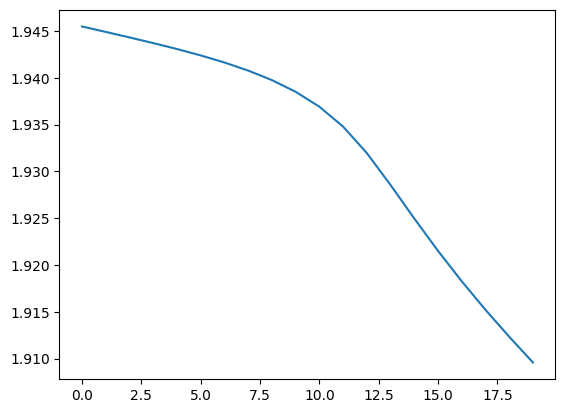

In [ ]:
plt.plot(mean_loss)

In [ ]:
torch.save(model.state_dict(), 'Model.pth')

In [ ]:
model_saved = nn.Sequential(
    nn.Linear(12288, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 7),
    nn.Softmax()
)
model_saved.load_state_dict(torch.load('Model.pth'))

<All keys matched successfully>

In [ ]:
accurate_predictions = 0
total_predictions = 0
ts = ToTensor()
dataloader = DataLoader(traffic_obj, batch_size=16, shuffle=False, num_workers=4,drop_last=True)
for i_batch, sample_batched in enumerate(dataloader):
      optimizer.zero_grad()
      image, label = sample_batched['image'].squeeze(dim=1), sample_batched['label'].squeeze(dim=1)
      outputs = model_saved(image)
      targets = label
      predicted_index = outputs.detach().cpu().numpy().argmax(axis=1)
      target_index = targets.detach().cpu().numpy().argmax(axis=1)
      # print('!!!!')
      # print(predicted_index)
      # print(target_index)
      # print('!!!!')
      # print(np.sum(predicted_index==target_index))

      accurate_predictions += np.sum(predicted_index==target_index)
      total_predictions += target_index.shape[0]
      accuracy = accurate_predictions/total_predictions * 100

print(f"Accurate predictions: {accurate_predictions}, Total predictions: {total_predictions}, yields accuracy: {accuracy:0.2f}")

Accurate predictions: 1349, Total predictions: 4656, yields accuracy: 28.97
